In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import seaborn as sns
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
from astropy.wcs import WCS
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from pysinopsis.output import SinopsisCube
from toolbox.kubevizResults import kubevizResults as kv
from astropy.io import fits
from toolbox.wololo import redshift2lumdistance, arcsectokpc
import scipy.stats

pio.templates.default = 'plotly_white'

sns.set_style('ticks')

In [17]:
data_dir = 'C:/Users/ariel/Workspace/GASP/High-z/PSB Regions/Data/'
highz_dir = 'C:/Users/ariel/Workspace/GASP/High-z/'
plots_dir = 'C:/Users/ariel/Workspace/GASP/High-z/PSB regions/Plots/'
bpt_dir = 'C:/Users/ariel/Workspace/GASP/High-z/Data/Emission/'

sample = pd.read_csv(data_dir + 'galaxy_sample.csv')
sample['category'] = sample['Category']
classification_maps = pickle.load(open(data_dir + 'classification_cnn.pkl', 'rb'))
ps_sample = pd.read_csv(data_dir + 'PS_galaxy_sample.csv')
ews = pd.read_csv(data_dir + 'ew_classes_cnn.csv')
ellipse_parameters = pd.read_table(highz_dir + 'Data/ellipse_axes_v2.cat', delim_whitespace=True)
ellipse_parameters = ellipse_parameters.sort_values('name')

In [18]:
jellyfish_table = sample[sample['category'] == 'Jellyfish']
truncated_table = sample[sample['category'] == 'Truncated Disk']

jellyfish_sample = sample[sample['category'] == 'Jellyfish']
truncated_sample = sample[sample['category'] == 'Truncated Disk']

In [20]:
plot_flag = jellyfish_table['sf_fraction'] < 0.9
jellyfish_sample[plot_flag]

,ID,RA,Dec,z,Category,Ha_in,n_spaxels,n_disk,n_spaxels_disk,flux_spaxels,...,oii_displacement,oii_displacement_out,dot_product_normed,dot_product_out_normed,oii_displacement_normed,oii_displacement_out_normed,g_center_x,g_center_y,circularized_radius,category
2,A2744_06,00:14:19.44,-30:23:26.96,0.29330,Jellyfish,True,715.0,294.0,292.0,2696.050293,...,8.414508,25.282567,-0.704524,-0.701963,0.864171,2.596523,29.416133,58.963455,9.737084,Jellyfish
18,A370_01,02:39:54.452,-01:33:36.41,0.37380,Jellyfish,True,717.0,504.0,438.0,3060.980713,...,8.820074,25.550886,-0.491031,-0.475235,0.740213,2.144325,29.647746,26.573376,11.915585,Jellyfish
20,A370_03,02:39:54.044,-01:33:52.09,0.35730,Jellyfish,True,306.0,139.0,117.0,849.871277,...,6.553673,17.297274,-1.016418,-1.018884,1.070372,2.825059,15.193057,37.368491,6.122800,Jellyfish
23,A370_06,02:39:51.031,-01:33:45.05,0.35926,Jellyfish,True,366.0,230.0,177.0,1430.758179,...,8.956427,15.230433,-0.327656,-0.324387,1.176052,1.999880,36.243620,22.314543,7.615673,Jellyfish
25,A370_08,02:39:54.759,-01:34:53.29,0.38720,Jellyfish,True,871.0,236.0,192.0,1230.122437,...,25.093065,36.033760,-0.591560,-0.581286,3.022582,4.340442,39.262609,62.026720,8.301864,Jellyfish
77,SMACS2031_01,20:31:53.24,-40:37:03.6,0.35230,Jellyfish,True,605.0,221.0,221.0,1706.093262,...,3.257390,9.396535,-0.001431,0.048335,0.376418,1.085848,26.013533,19.177315,8.653641,Jellyfish


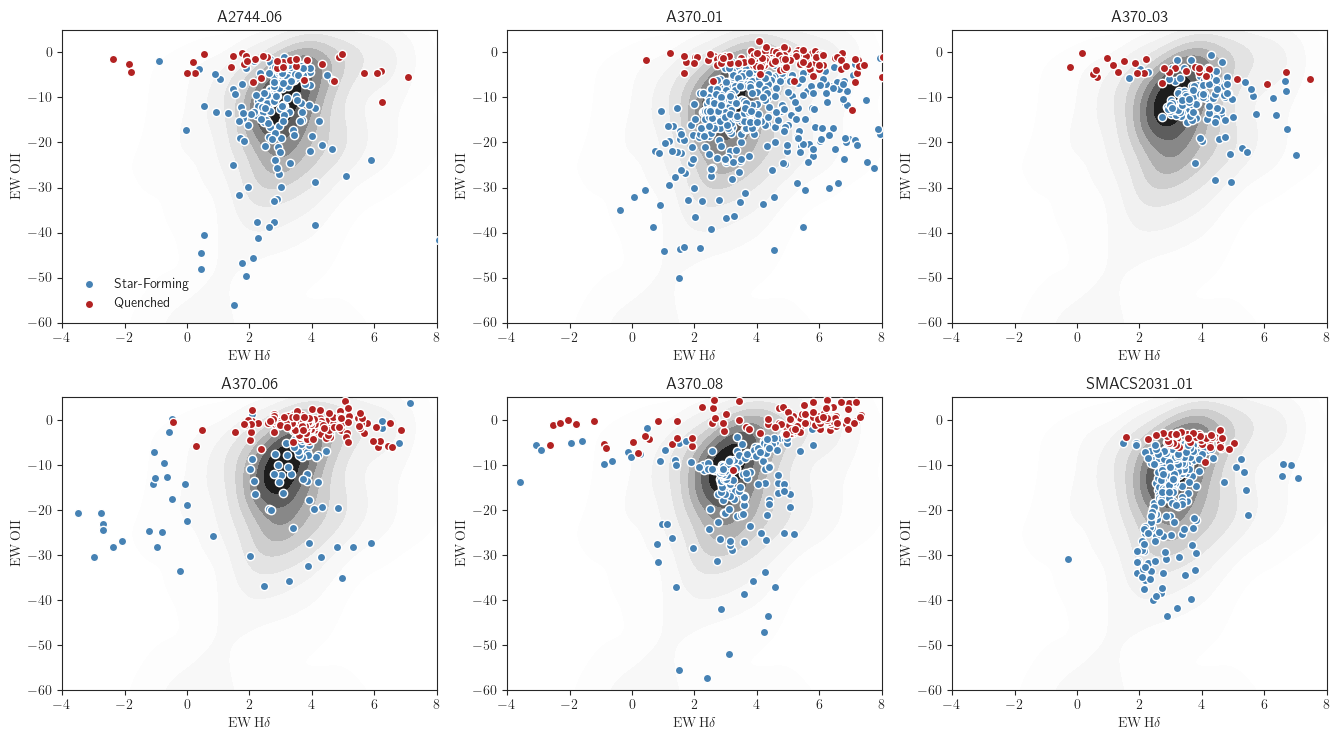

In [19]:
galaxies = jellyfish_table[plot_flag]['ID'].to_list()

fig = plt.figure(figsize=(13.5, 7.5))

for i in range(6):
    
    galaxy = galaxies[i]

    ax = plt.subplot(2, 3, i+1)

    sns.kdeplot(data=ews, x='Hd', y='Oii', cmap='Greys', fill=True, zorder=1)

    galaxy_table = ews[ews['galaxy'] == galaxy]
    ax.scatter(galaxy_table['Hd'][galaxy_table['class'] == 'Star-Forming'], galaxy_table['Oii'][galaxy_table['class'] == 'Star-Forming'],
                color='steelblue', label='Star-Forming', edgecolors='w', zorder=10)
    ax.scatter(galaxy_table['Hd'][galaxy_table['class'] == 'Quenched'], galaxy_table['Oii'][galaxy_table['class'] == 'Quenched'],
                color='firebrick', label='Quenched', edgecolors='w', zorder=11)

    ax.set_title(galaxy)

    ax.set_xlim(-4, 8)
    ax.set_ylim(-60, 5)

    ax.set_xlabel(r'$\mathrm{EW \, H\delta}$')
    ax.set_ylabel(r'$\mathrm{EW \, OII}$')

    if i == 0:
        plt.legend(frameon=False)

fig.tight_layout()

### Plotting a galery of galaxies:

['A2744_06', 'A370_01', 'A370_03', 'A370_06', 'A370_08', 'SMACS2031_01']


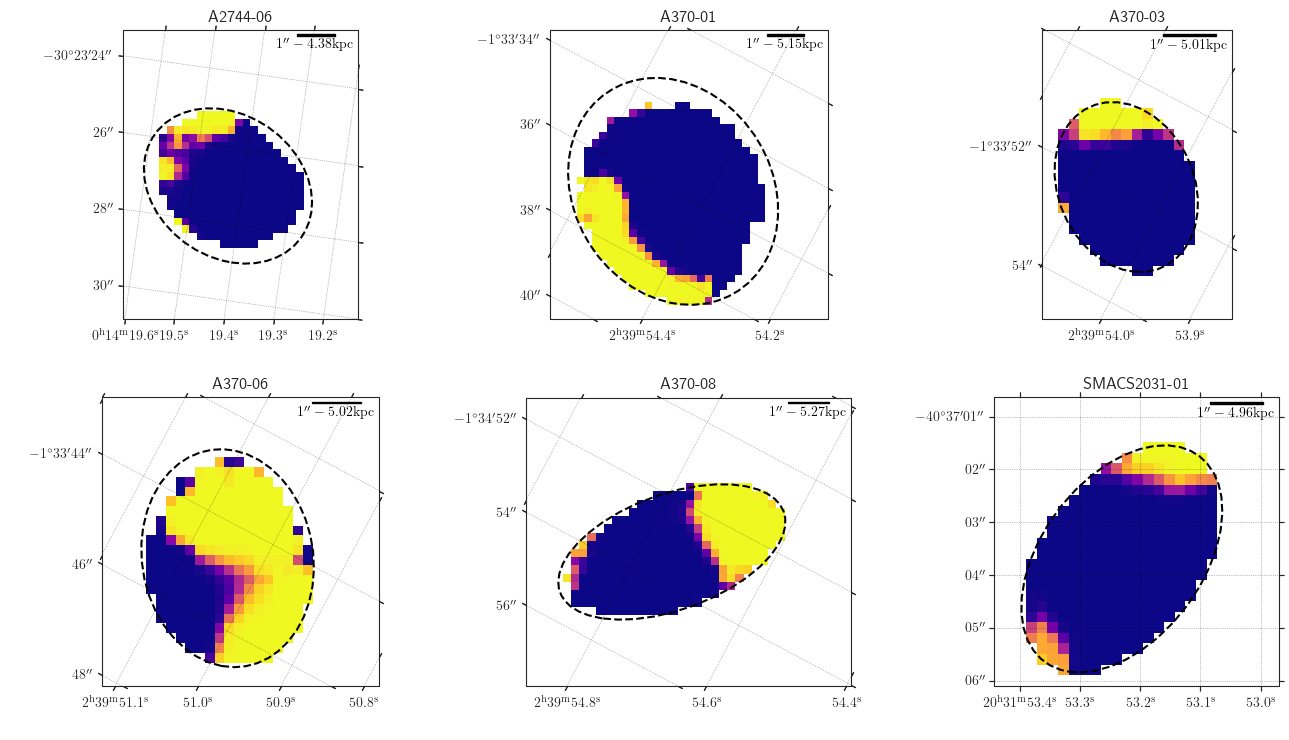

In [21]:
sns.set_style('ticks')

galaxies = jellyfish_table[plot_flag]['ID'].to_list()
redshifts = jellyfish_sample[plot_flag]['z'].to_list()
print(galaxies)

fig = plt.figure(figsize=(13.5, 7.5))

for i in range(6):
    
    try:
        ellipse = np.genfromtxt(highz_dir + 'Data/Contours/' + galaxies[i] + '_contours_3s_ellipse.txt').transpose()
    except:
        ellipse = np.genfromtxt(highz_dir + 'Data/Contours/' + galaxies[i] + '_contours_3.0s_ellipse.txt').transpose()

    galaxy_path = 'C:/Users/ariel/Workspace/GASP/High-z/SINOPSIS/' + galaxies[i] + '/'

    sinopsis_cube = SinopsisCube(galaxy_path)   

    emission_only = kv(highz_dir + 'Data/Emission/' + galaxies[i] + '_DATACUBE_FINAL_v1_ec_eo_res_gau_spax_noflag.fits')

    oii_raw = emission_only.get_flux('o2t')
    sn_oii = emission_only.get_snr('o2t')
    sn_mask = (oii_raw <= 0) | (sn_oii < 3) | np.isnan(oii_raw) | np.isnan(sn_oii)| np.isinf(oii_raw) | np.isinf(sn_oii)
    oii = np.ma.masked_array(oii_raw, mask=sn_mask)
    oii_label_image = (~sn_mask)
    oii[np.isnan(oii) | np.isinf(oii)] = 0

    wcs = WCS(sinopsis_cube.obs_header['flux']).celestial

    ax = plt.subplot(2, 3, i+1, projection=wcs)

    map = classification_maps[galaxies[i]]['probability']

    map_plot = plt.imshow(map, origin='lower', cmap='plasma', vmin=0, vmax=1)

    scalebar = AnchoredSizeBar(ax.transData,
                               5, r'$1^{\prime\prime}-%0.2f\mathrm{kpc}$' % arcsectokpc(redshifts[i]), 'upper right',
                               pad=0.2,
                               color='black',
                               frameon=False,
                               size_vertical=0.2)

    ax.add_artist(scalebar)

    split_name = galaxies[i].split('_')
    galaxy_name = split_name[0] + '-' + split_name[1]

    ax.set_title(galaxy_name)
    
    plt.plot(ellipse[0], ellipse[1], '--k')
    plt.xlim(0.85 * np.min(ellipse[0]), 1.15 * np.max(ellipse[0]))
    plt.ylim(0.85 * np.min(ellipse[1]), 1.15 * np.max(ellipse[1]))

    plt.xlabel(' ')
    plt.ylabel(' ')

    ax.grid(lw=0.5, alpha=0.5, color='k', ls='dotted')

fig.tight_layout()

plt.savefig(plots_dir + 'class_maps.png')

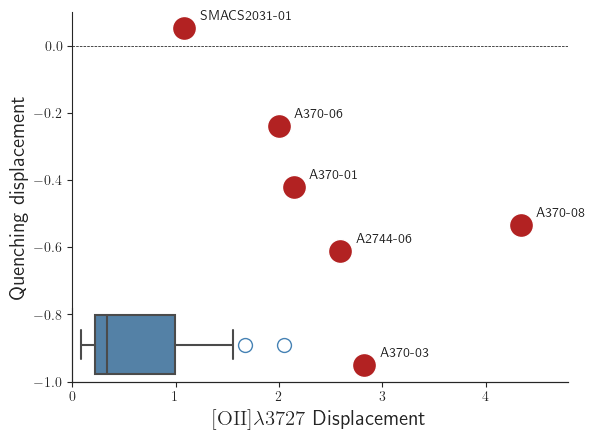

In [16]:
flag = (sample['category'] == 'Jellyfish') & (sample['sf_fraction'] < 0.9)
mostly_sf_flag = (sample['category'] == 'Jellyfish') & (sample['sf_fraction'] > 0.9) & (sample['ID'] != 'AS1063NE_06')

plt.figure()

plt.scatter(sample['oii_displacement_out_normed'][flag], 
            sample['dot_product_normed'][flag], s=300,  
            color='firebrick', edgecolors='w')

for i in range(flag.sum()):
      galaxy = sample['ID'][flag].to_list()[i]
      galaxy_label = galaxy.split('_')[0] + '-' + galaxy.split('_')[1]
      plt.annotate(galaxy_label, xy=(sample['oii_displacement_out_normed'][flag].to_list()[i] + 0.15, 
                                     sample['dot_product_normed'][flag].to_list()[i] + 0.025))

ax = plt.gca()
inset_ax = ax.inset_axes([0, 0.0, 1, 0.2])
inset_ax.set_xticklabels([])
inset_ax.set_yticklabels([])
inset_ax.spines["top"].set_visible(False)
inset_ax.spines["right"].set_visible(False)
inset_ax.patch.set_alpha(0)
inset_ax.tick_params(axis='both', length=0)

sns.boxplot(x=sample['oii_displacement_out_normed'][mostly_sf_flag].tolist(), 
            ax=inset_ax,  whis=[0, 90], color='steelblue',
            flierprops = dict(marker='o', markerfacecolor='none', markersize=10,
                  linestyle='none', markeredgecolor='steelblue'))

ax.axhline(y=0, linestyle='dashed', color='k', linewidth=0.5)

inset_ax.set_xlim(0, 4.8)

plt.xlim(0, 4.8)
plt.ylim(-1, 0.1)

sns.despine()

plt.xlabel(r'$[\mathrm{\sc{OII}}]\lambda3727$ Displacement', fontsize=15)
plt.ylabel('Quenching displacement', fontsize=15)

plt.savefig('C:/Users/ariel/Workspace/GASP/High-z/PSB regions/Plots/diplacements.png', dpi=300)


['A2744_06', 'A370_01', 'A370_03', 'A370_06', 'A370_08', 'SMACS2031_01']


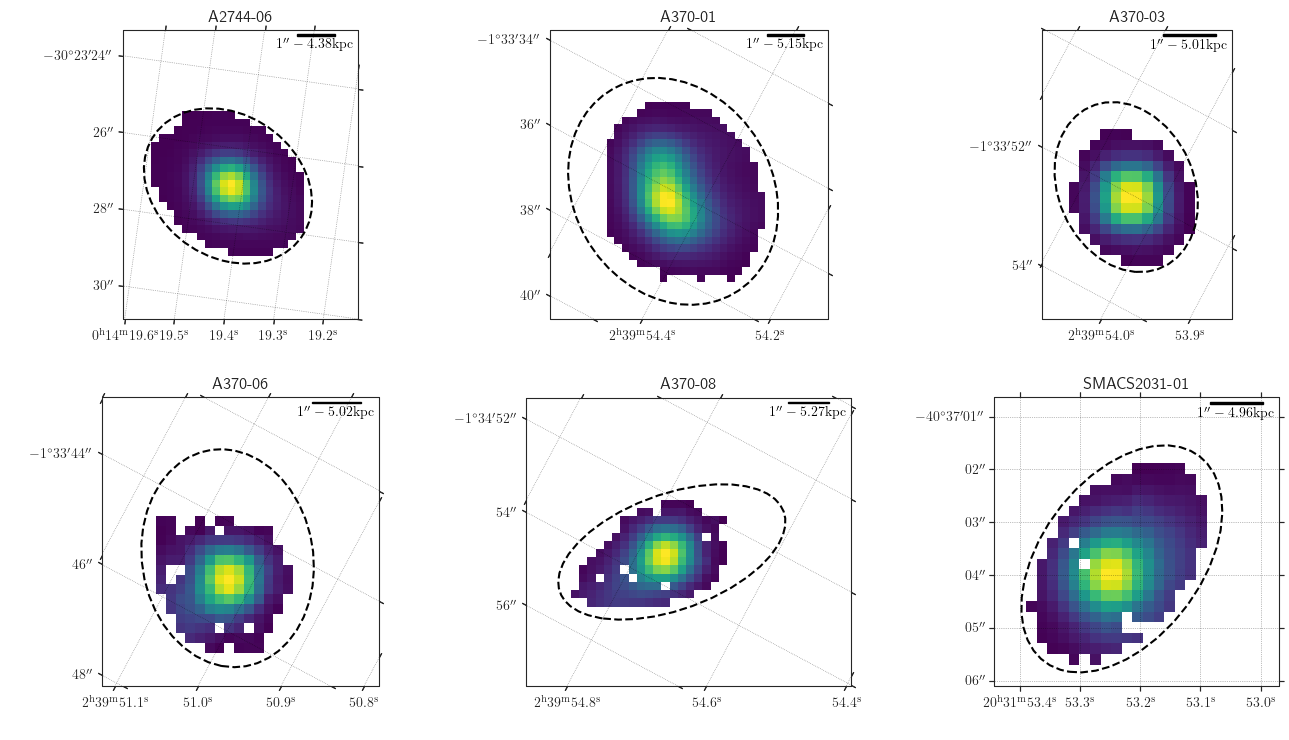

In [19]:
sns.set_style('ticks')

galaxies = jellyfish_table[plot_flag]['galaxy'].to_list()
redshifts = jellyfish_sample[plot_flag]['z'].to_list()
print(galaxies)

fig = plt.figure(figsize=(13.5, 7.5))

for i in range(6):
    
    contours = fits.open(highz_dir + 'Data/Contours/' + galaxies[i] + '_mask_ellipse.fits')[0].data
    g_band = fits.open(highz_dir + 'Data/G-Band/' + galaxies[i] + '_DATACUBE_FINAL_v1_SDSS_g.fits')[1].data

    try:
        ellipse = np.genfromtxt(highz_dir + 'Data/Contours/' + galaxies[i] + '_contours_3s_ellipse.txt').transpose()
    except:
        ellipse = np.genfromtxt(highz_dir + 'Data/Contours/' + galaxies[i] + '_contours_3.0s_ellipse.txt').transpose()

    galaxy_path = 'C:/Users/ariel/Workspace/GASP/High-z/SINOPSIS/' + galaxies[i] + '/'

    sinopsis_cube = SinopsisCube(galaxy_path)   

    emission_only = kv(highz_dir + 'Data/Emission/' + galaxies[i] + '_DATACUBE_FINAL_v1_ec_eo_res_gau_spax_noflag.fits')

    ha_raw = emission_only.get_flux('Ha')
    sn_ha = emission_only.get_snr('Ha')
    sn_mask = (ha_raw <= 0) | (sn_ha < 3) | np.isnan(ha_raw) | np.isnan(sn_ha)| np.isinf(ha_raw) | np.isinf(sn_ha)
    ha = np.ma.masked_array(ha_raw, mask=sn_mask | (contours < 5))
    ha[np.isnan(ha) | np.isinf(ha)] = 0

    wcs = WCS(sinopsis_cube.obs_header['flux']).celestial

    ax = plt.subplot(2, 3, i+1, projection=wcs)

    map_plot = plt.imshow(ha, origin='lower', cmap='viridis')

    scalebar = AnchoredSizeBar(ax.transData,
                               5, r'$1^{\prime\prime}-%0.2f\mathrm{kpc}$' % arcsectokpc(redshifts[i]), 'upper right',
                               pad=0.2,
                               color='black',
                               frameon=False,
                               size_vertical=0.2)

    ax.add_artist(scalebar)

    split_name = galaxies[i].split('_')
    galaxy_name = split_name[0] + '-' + split_name[1]

    ax.set_title(galaxy_name)
    
    plt.plot(ellipse[0], ellipse[1], '--k')
    plt.xlim(0.85 * np.min(ellipse[0]), 1.15 * np.max(ellipse[0]))
    plt.ylim(0.85 * np.min(ellipse[1]), 1.15 * np.max(ellipse[1]))

    plt.xlabel(' ')
    plt.ylabel(' ')

    ax.grid(lw=0.5, alpha=0.5, color='k', ls='dotted')

fig.tight_layout()


In [27]:
galaxies = jellyfish_table[plot_flag]['galaxy'].to_list()
redshifts = jellyfish_sample[plot_flag]['z'].to_list()
print(galaxies)

masses_quenching = []
ha_luminosities_quenching = []
galaxy_list_quenching = []

for i in range(len(galaxies)):

    sf_spaxels = classification_maps[galaxies[i]]['class'] == 'Star-Forming'

    ellipse_galaxy = ellipse_parameters[ellipse_parameters['name'] == galaxy]
    ellipse_ratio = ellipse_galaxy['B']/ellipse_galaxy['A'] 

    distance = redshift2lumdistance(redshifts[i], unit='cm')
    kpc_scale = 0.2 * arcsectokpc(redshifts[i]) 
    
    contours = fits.open(highz_dir + 'Data/Contours/' + galaxies[i] + '_mask_ellipse.fits')[0].data

    galaxy_path = 'C:/Users/ariel/Workspace/GASP/High-z/SINOPSIS/' + galaxies[i] + '/'

    sinopsis_cube = SinopsisCube(galaxy_path)  

    if sample['Ha_in'].to_list()[i]:

        bpt_map = fits.open(bpt_dir + galaxies[i] + '_bpt_classification_mario.fits')[0].data[0, :, :]
        bpt_map = np.ma.masked_array(bpt_map, np.isnan(bpt_map))

        emission_only = kv(highz_dir + 'Data/Emission/' + galaxies[i] + '_DATACUBE_FINAL_v1_ec_eo_res_gau_spax_noflag.fits')

        ha_raw = emission_only.get_flux('Ha')
        sn_ha = emission_only.get_snr('Ha')
        sn_mask = (ha_raw <= 0) | (sn_ha < 2) | np.isnan(ha_raw) | np.isnan(sn_ha)| np.isinf(ha_raw) | np.isinf(sn_ha)
        
        mass_raw = sinopsis_cube.properties['TotMass2']
        
        mask = sn_mask | (contours < 5) | mass_raw.mask | ~sf_spaxels | (bpt_map != 1)
        
        ha = np.ma.masked_array(ha_raw, mask=mask) 
        mass = np.ma.masked_array(mass_raw, mask=mask)

    else:
        continue

    for ha_item in ha[~ha.mask].ravel():
        ha_luminosities_quenching.append(ha_item * 1e-20 * 4 * np.pi * distance **2 / kpc_scale ** 2 / ellipse_ratio)

    for mass_item in mass[~mass.mask].ravel():
        masses_quenching.append(mass_item / kpc_scale ** 2 / ellipse_ratio)
    
    for j in range(len(ha[~ha.mask].ravel())):
        galaxy_list_quenching.append(galaxies[i])
    
ha_luminosities_quenching = np.array(ha_luminosities_quenching)
masses_quenching = np.array(masses_quenching)
galaxy_list_quenching = np.array(galaxy_list_quenching)

galaxies = jellyfish_table[~plot_flag]['galaxy'].to_list()
redshifts = jellyfish_sample[~plot_flag]['z'].to_list()
print(galaxies)

masses = []
ha_luminosities = []
galaxy_list = []

for i in range(len(galaxies)):

    ellipse_galaxy = ellipse_parameters[ellipse_parameters['name'] == galaxy]
    ellipse_ratio = ellipse_galaxy['B']/ellipse_galaxy['A'] 

    distance = redshift2lumdistance(redshifts[i], unit='cm')
    kpc_scale = 0.2 * arcsectokpc(redshifts[i]) 
    
    contours = fits.open(highz_dir + 'Data/Contours/' + galaxies[i] + '_mask_ellipse.fits')[0].data

    galaxy_path = 'C:/Users/ariel/Workspace/GASP/High-z/SINOPSIS/' + galaxies[i] + '/'

    sinopsis_cube = SinopsisCube(galaxy_path)   

    if sample['Ha_in'].to_list()[i]:

        try:
            bpt_map = fits.open(bpt_dir + galaxies[i] + '_bpt_classification_mario.fits')[0].data[0, :, :]
            bpt_map = np.ma.masked_array(bpt_map, np.isnan(bpt_map))
        except:
            continue

        emission_only = kv(highz_dir + 'Data/Emission/' + galaxies[i] + '_DATACUBE_FINAL_v1_ec_eo_res_gau_spax_noflag.fits')

        ha_raw = emission_only.get_flux('Ha')
        sn_ha = emission_only.get_snr('Ha')
        sn_mask = (ha_raw <= 0) | (sn_ha < 2) | np.isnan(ha_raw) | np.isnan(sn_ha)| np.isinf(ha_raw) | np.isinf(sn_ha)
        
        mass_raw = sinopsis_cube.properties['TotMass2']
        
        mask = sn_mask | (contours < 5) | mass_raw.mask
        
        ha = np.ma.masked_array(ha_raw, mask=mask) 
        mass = np.ma.masked_array(mass_raw, mask=mask)
    else:
        continue

    for ha_item in ha[~ha.mask].ravel():
        ha_luminosities.append(ha_item * 1e-20 * 4 * np.pi * distance **2 / kpc_scale ** 2 / ellipse_ratio)

    for mass_item in mass[~mass.mask].ravel():
        masses.append(mass_item / kpc_scale ** 2 / ellipse_ratio)

    for j in range(len(ha[~ha.mask].ravel())):
        galaxy_list.append(galaxies[i])
    
ha_luminosities = np.array(ha_luminosities)
masses = np.array(masses)
galaxy_list = np.array(galaxy_list)

['A2744_06', 'A370_01', 'A370_03', 'A370_06', 'A370_08', 'SMACS2031_01']
['A2744_09', 'A2744_10', 'A2744_16', 'A370_02', 'A370_07', 'A370_09', 'A370_17', 'AS1063NE_06', 'MACS0416S_02', 'MACS0940_01', 'MACS1206_03', 'MACS1206_08', 'MACS1206_21', 'MACS1206_22']
No emission line mask
Cannot read flux unit from  1e-40 erg2 / (Angstrom2 cm4 s2) , trying to split()[0] instead: 1e-40


(array([0.11366127, 0.22732254, 0.44517331, 0.73879825, 0.64408053,
        0.59672166, 0.62513698, 0.6535523 , 0.57777812, 0.44517331]),
 array([-3.18498737, -2.98764744, -2.79030751, -2.59296759, -2.39562766,
        -2.19828774, -2.00094781, -1.80360788, -1.60626796, -1.40892803,
        -1.2115881 ]),
 [<matplotlib.patches.Polygon at 0x1a51001cc10>])

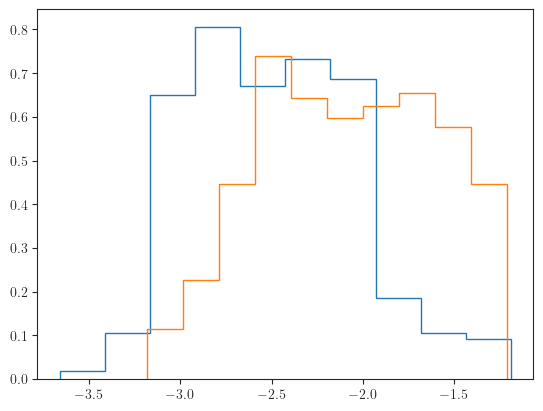

In [28]:
plt.hist(np.log10(ha_luminosities / (10 ** 41.28)), bins=10, density=True, histtype='step')
plt.hist(np.log10(ha_luminosities_quenching / (10 ** 41.28)), bins=10, density=True, histtype='step')

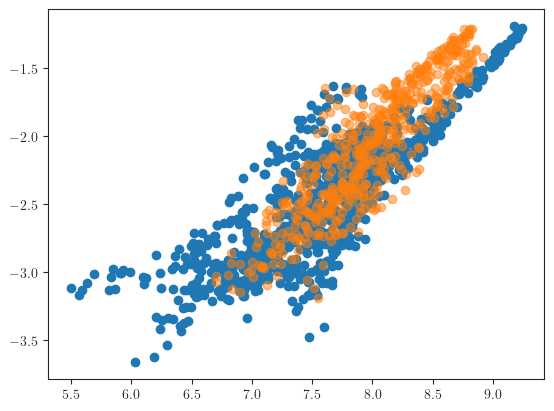

In [29]:
plt.scatter(np.log10(masses), np.log10(ha_luminosities / (10 ** 41.28)))
plt.scatter(np.log10(masses_quenching), np.log10(ha_luminosities_quenching / (10 ** 41.28)), alpha=0.5)

In [30]:
x = np.linspace(6.5, 9.5)

correlation = scipy.stats.linregress(np.log10(masses)[:,0], np.log10(ha_luminosities / (10 ** 41.28))[:,0])
print(correlation.slope, correlation.intercept)

correlation_quenching = scipy.stats.linregress(np.log10(masses_quenching)[:,0], np.log10(ha_luminosities_quenching / (10 ** 41.28))[:,0])
print(correlation_quenching.slope, correlation_quenching.intercept)


a, b, a_err, b_err = correlation.slope, correlation.intercept, correlation.stderr, correlation.intercept_stderr
a_q, b_q, a_q_err, b_q_err = correlation_quenching.slope, correlation_quenching.intercept, correlation_quenching.stderr, correlation_quenching.intercept_stderr

0.6015294262350385 -7.034608383056417
0.8808242150361841 -9.109901604023655


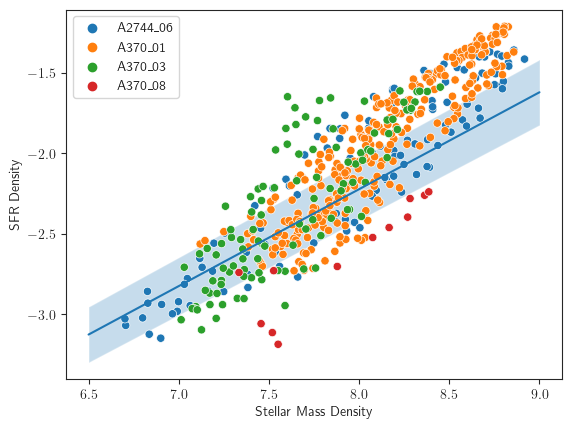

In [31]:
x = np.linspace(6.5, 9)

plt.plot(x, a * x + b)

plt.fill_between(x, (a - a_err) * x + b - b_err, (a + a_err) * x + b + b_err, alpha=0.25)
sns.scatterplot(x=np.log10(masses_quenching)[:,0].tolist(), y=np.log10(ha_luminosities_quenching / (10 ** 41.28))[:,0].tolist(), hue=galaxy_list_quenching)

plt.xlabel('Stellar Mass Density')
plt.ylabel('SFR Density')

plt.savefig(plots_dir + 'masssfr.png', dpi=300)

<Axes: >

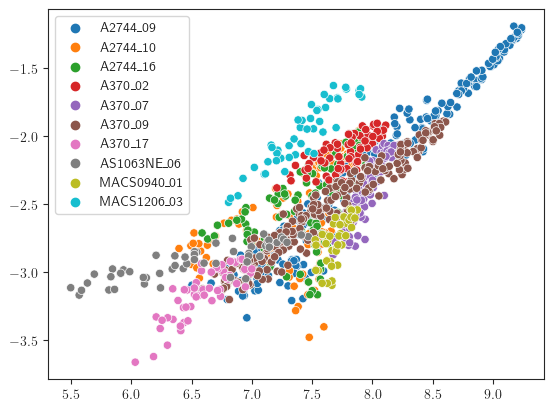

In [128]:
sns.scatterplot(x=np.log10(masses)[:,0].tolist(), y=np.log10(ha_luminosities / (10 ** 41.28))[:,0].tolist(), hue=galaxy_list)

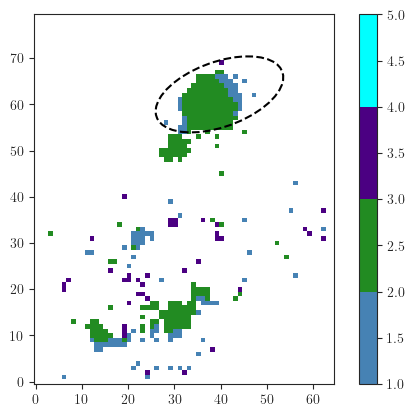

: 

In [149]:
from matplotlib import colors
cmap = colors.ListedColormap(['steelblue', 'forestgreen', 'indigo', 'cyan'])

bpt_dir = 'C:/Users/ariel/Workspace/GASP/High-z/Data/Emission/'

galaxy = 'A370_08'

try:
    ellipse = np.genfromtxt(highz_dir + 'Data/Contours/' + galaxy + '_contours_3s_ellipse.txt').transpose()
except:
    ellipse = np.genfromtxt(highz_dir + 'Data/Contours/' + galaxy + '_contours_3.0s_ellipse.txt').transpose()


bpt_map = fits.open(bpt_dir + galaxy + '_bpt_classification_mario.fits')[0].data[0, :, :]
bpt_map = np.ma.masked_array(bpt_map, np.isnan(bpt_map))

plt.imshow(bpt_map, origin='lower', cmap=cmap, vmin=1, vmax=5)
plt.colorbar()

plt.plot(ellipse[0], ellipse[1], '--k')

In [131]:
bpt_map = fits.open(bpt_dir + galaxy + '_bpt_classification_mario.fits')
bpt_map[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                   65                                                  
NAXIS2  =                   80                                                  
NAXIS3  =                    4                                                  
CLASS1  = 'StarForming'                                                         
CLASS2  = 'Composite'                                                           
CLASS3  = 'AGN     '                                                            
CLASS4  = 'liners  '                                                            
P1      = 'NII     '                                                            
P2      = 'SII     '                                                            
P3      = 'OI      '        

In [36]:
ps_sample['quenching_category'] = ps_sample['Category']
ps_sample = ps_sample[(ps_sample['Category'] != 'Truncated Disk') & (ps_sample['ID'] != 'MACS1206_20')]
ps_sample['v_abs'] = np.absolute(ps_sample['v_rel']) 

quenching_list = jellyfish_table['galaxy'][jellyfish_table['sf_fraction'] < 0.9].tolist()
sf_jelly_list = jellyfish_table['galaxy'][jellyfish_table['sf_fraction'] > 0.9].tolist()

ps_sample = ps_sample.reset_index(drop=True)

for i in range(len(ps_sample)):

    if ps_sample['ID'].tolist()[i] in quenching_list:
        ps_sample.loc[i, 'Category'] = 'Quenching Jellyfish'

In [37]:
fig = px.box(ps_sample, x='v_abs', color='Category', width=900, height=600, hover_data=['ID'])

fig.show()

['AS1063SW_02', 'AS1063SW_04', 'MACS0416N_01', 'MACS0940_03', 'MACS1206_07']
No emission line mask


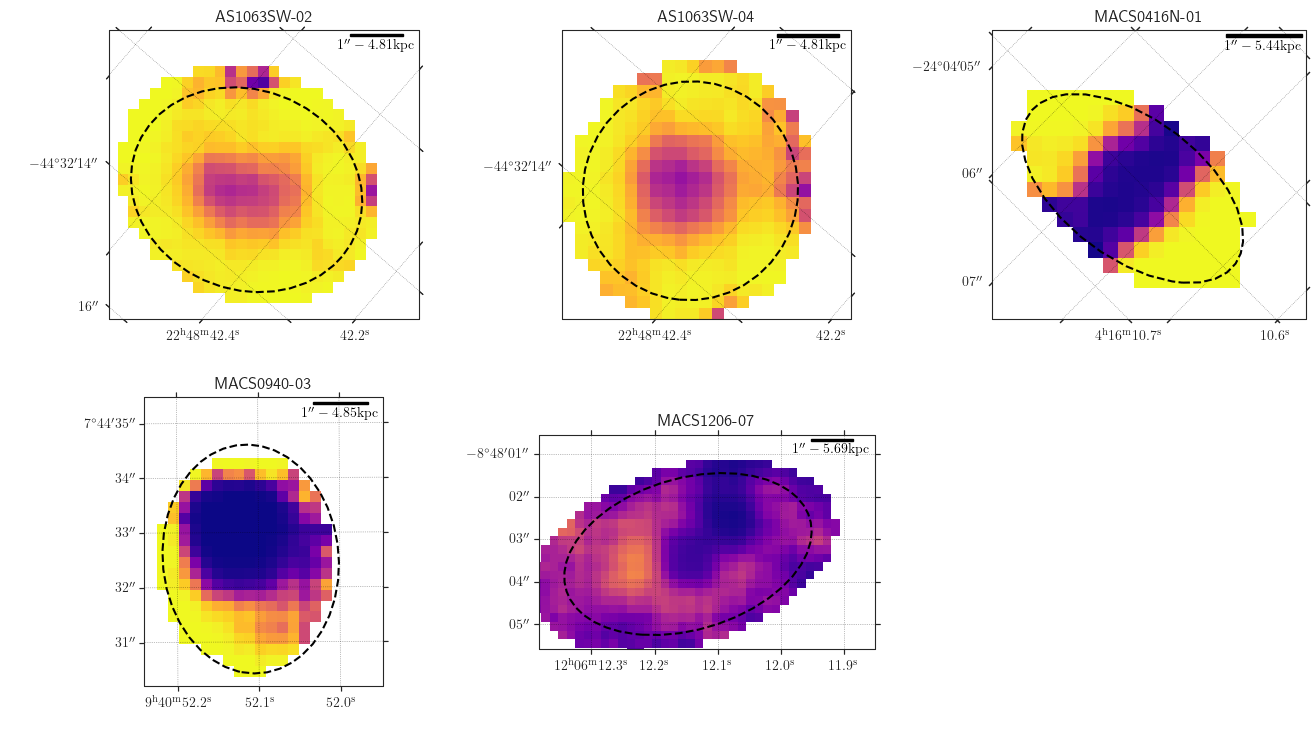

In [19]:
sns.set_style('ticks')

galaxies = truncated_table['galaxy'].to_list()
redshifts = truncated_sample['z'].to_list()
print(galaxies)

fig = plt.figure(figsize=(13.5, 7.5))

for i in range(5):
    
    try:
        ellipse = np.genfromtxt(highz_dir + 'Data/Contours/' + galaxies[i] + '_contours_5s_ellipse.txt').transpose()
    except:
        ellipse = np.genfromtxt(highz_dir + 'Data/Contours/' + galaxies[i] + '_contours_5.0s_ellipse.txt').transpose()

    galaxy_path = 'C:/Users/ariel/Workspace/GASP/High-z/SINOPSIS/' + galaxies[i] + '/'

    sinopsis_cube = SinopsisCube(galaxy_path)   

    wcs = WCS(sinopsis_cube.obs_header['flux']).celestial

    ax = plt.subplot(2, 3, i+1, projection=wcs)

    map = classification_maps[galaxies[i]]['probability']

    map_plot = plt.imshow(map, origin='lower', cmap='plasma', vmin=0, vmax=1)

    scalebar = AnchoredSizeBar(ax.transData,
                               5, r'$1^{\prime\prime}-%0.2f\mathrm{kpc}$' % arcsectokpc(redshifts[i]), 'upper right',
                               pad=0.2,
                               color='black',
                               frameon=False,
                               size_vertical=0.2)

    ax.add_artist(scalebar)

    split_name = galaxies[i].split('_')
    galaxy_name = split_name[0] + '-' + split_name[1]

    ax.set_title(galaxy_name)
    
    plt.plot(ellipse[0], ellipse[1], '--k')
    plt.xlim(0.85 * np.min(ellipse[0]), 1.15 * np.max(ellipse[0]))
    plt.ylim(0.85 * np.min(ellipse[1]), 1.15 * np.max(ellipse[1]))

    plt.xlabel(' ')
    plt.ylabel(' ')

    ax.grid(lw=0.5, alpha=0.5, color='k', ls='dotted')

fig.tight_layout()


In [74]:
truncated_table

,galaxy,category,mass,mass_corr,classification_flag,n_classified,n_sf,n_psb,n_intermediate,classified_fraction,...,mass_center_x,mass_center_y,dot_product,dot_product_out,oii_displacement,oii_displacement_out,dot_product_normed,dot_product_out_normed,oii_displacement_normed,oii_displacement_out_normed
45,AS1063SW_02,Truncated Disk,4.402237e+10,4.557432e+10,True,419.0,2.0,417.0,0.0,1.126344,...,4.402237e+10,4.402237e+10,4.402237e+10,4.402237e+10,4.402237e+10,4.402237e+10,4.402237e+10,4.402237e+10,4.402237e+10,4.402237e+10
47,AS1063SW_04,Truncated Disk,5.450188e+10,5.450188e+10,True,330.0,0.0,330.0,0.0,1.000000,...,5.450188e+10,5.450188e+10,5.450188e+10,5.450188e+10,5.450188e+10,5.450188e+10,5.450188e+10,5.450188e+10,5.450188e+10,5.450188e+10
48,MACS0416N_01,Truncated Disk,2.421132e+10,2.508419e+10,True,143.0,50.0,93.0,0.0,1.144000,...,2.421132e+10,2.421132e+10,2.421132e+10,2.421132e+10,2.421132e+10,2.421132e+10,2.421132e+10,2.421132e+10,2.421132e+10,2.421132e+10
52,MACS0940_03,Truncated Disk,1.503776e+10,1.701724e+10,True,251.0,106.0,145.0,0.0,1.321053,...,1.503776e+10,1.503776e+10,1.503776e+10,1.503776e+10,1.503776e+10,1.503776e+10,1.503776e+10,1.503776e+10,1.503776e+10,1.503776e+10
59,MACS1206_07,Truncated Disk,3.351359e+11,3.351359e+11,True,600.0,320.0,280.0,0.0,1.000000,...,3.351359e+11,3.351359e+11,3.351359e+11,3.351359e+11,3.351359e+11,3.351359e+11,3.351359e+11,3.351359e+11,3.351359e+11,3.351359e+11


['AS1063SW_02', 'AS1063SW_04', 'MACS0416N_01', 'MACS0940_03', 'MACS1206_07']
No emission line mask


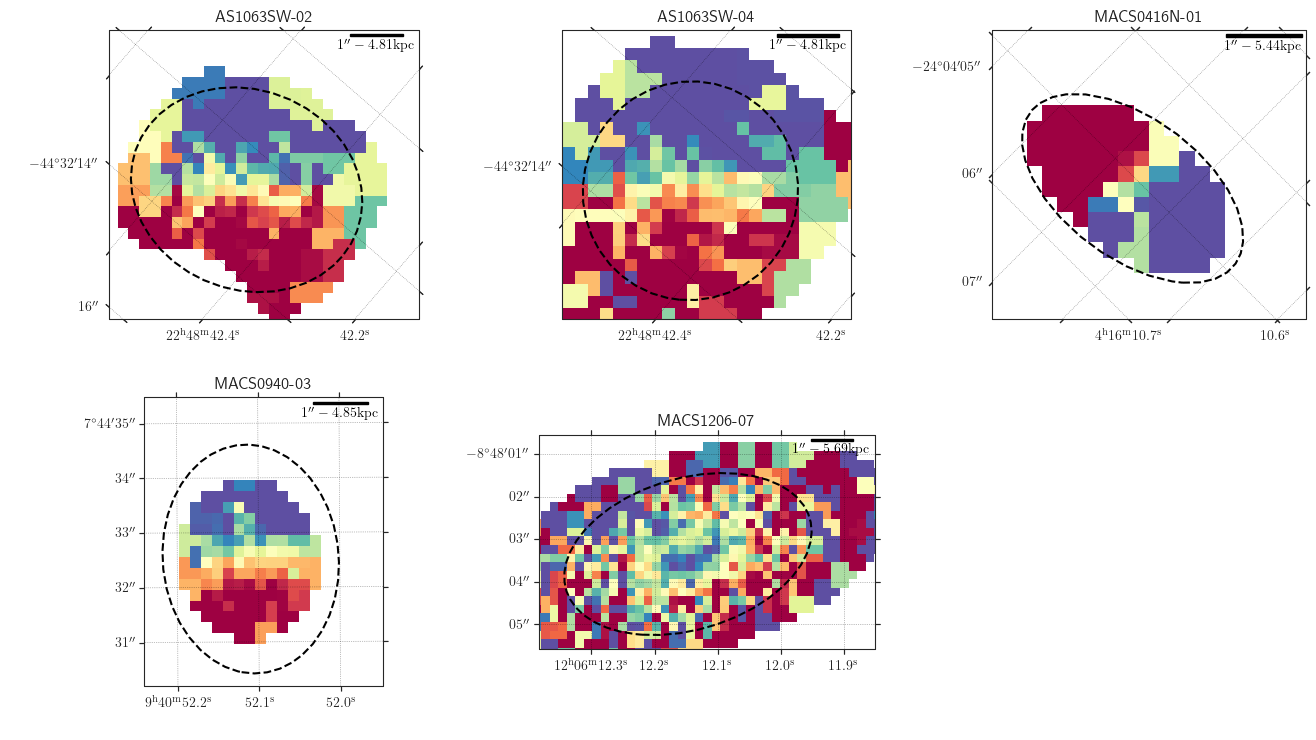

In [34]:
sns.set_style('ticks')

galaxies = truncated_table['galaxy'].to_list()
redshifts = truncated_sample['z'].to_list()
print(galaxies)

fig = plt.figure(figsize=(13.5, 7.5))

for i in range(5):
    
    try:
        ellipse = np.genfromtxt(highz_dir + 'Data/Contours/' + galaxies[i] + '_contours_5s_ellipse.txt').transpose()
    except:
        ellipse = np.genfromtxt(highz_dir + 'Data/Contours/' + galaxies[i] + '_contours_5.0s_ellipse.txt').transpose()

    galaxy_path = 'C:/Users/ariel/Workspace/GASP/High-z/SINOPSIS/' + galaxies[i] + '/'

    sinopsis_cube = SinopsisCube(galaxy_path)   

    redshift_cube = fits.open(galaxy_path + galaxies[i] + '_z_abs_mask.fits')[0].data
    redshift_cube = np.ma.masked_array(redshift_cube, mask=redshift_cube < 0)

    wcs = WCS(sinopsis_cube.obs_header['flux']).celestial

    ax = plt.subplot(2, 3, i+1, projection=wcs)

    map = 300000 * (redshift_cube - np.mean(redshift_cube))

    map_plot = plt.imshow(map, origin='lower', cmap='Spectral', vmin=-60, vmax=60)

    scalebar = AnchoredSizeBar(ax.transData,
                               5, r'$1^{\prime\prime}-%0.2f\mathrm{kpc}$' % arcsectokpc(redshifts[i]), 'upper right',
                               pad=0.2,
                               color='black',
                               frameon=False,
                               size_vertical=0.2)

    ax.add_artist(scalebar)

    split_name = galaxies[i].split('_')
    galaxy_name = split_name[0] + '-' + split_name[1]

    ax.set_title(galaxy_name)
    
    plt.plot(ellipse[0], ellipse[1], '--k')
    plt.xlim(0.85 * np.min(ellipse[0]), 1.15 * np.max(ellipse[0]))
    plt.ylim(0.85 * np.min(ellipse[1]), 1.15 * np.max(ellipse[1]))

    plt.xlabel(' ')
    plt.ylabel(' ')

    ax.grid(lw=0.5, alpha=0.5, color='k', ls='dotted')

fig.tight_layout()


In [23]:
truncated_table

,galaxy,category,mass,mass_corr,classification_flag,n_classified,n_sf,n_psb,n_intermediate,classified_fraction,sf_fraction,psb_fraction,intermediate_fraction,psb_center_x,psb_center_y,has_psb_regions
45,AS1063SW_02,Truncated Disk,4.402237e+10,4.557432e+10,True,318.0,0.0,241.0,77.0,1.042623,0.000000,0.757862,0.242138,0.0,0.0,True
47,AS1063SW_04,Truncated Disk,5.450188e+10,5.450188e+10,True,237.0,0.0,151.0,86.0,1.000000,0.000000,0.637131,0.362869,0.0,0.0,True
48,MACS0416N_01,Truncated Disk,2.421132e+10,2.508419e+10,True,123.0,42.0,59.0,22.0,1.098214,0.341463,0.479675,0.178862,0.0,0.0,True
52,MACS0940_03,Truncated Disk,1.503776e+10,1.701724e+10,True,243.0,99.0,74.0,70.0,1.342541,0.407407,0.304527,0.288066,0.0,0.0,True
60,MACS1206_07,Truncated Disk,3.351359e+11,3.351359e+11,True,411.0,113.0,0.0,298.0,1.000000,0.274939,0.000000,0.725061,0.0,0.0,False


In [72]:
properties_table[mostly_sf_flag]

,galaxy,category,mass,mass_corr,classification_flag,n_classified,n_sf,n_psb,n_intermediate,classified_fraction,...,mass_center_x,mass_center_y,dot_product,dot_product_out,oii_displacement,oii_displacement_out,dot_product_normed,dot_product_out_normed,oii_displacement_normed,oii_displacement_out_normed
5,A2744_09,Jellyfish,4.575693e+10,4.575693e+10,True,283.0,283.0,0.0,0.0,0.653580,...,20.660903,55.660346,-6.357097,-6.356933,7.507131,20.471073,-0.637123,-0.637107,0.752382,2.051658
6,A2744_10,Jellyfish,2.663789e+09,2.670274e+09,True,125.0,125.0,0.0,0.0,0.838926,...,20.193897,19.642545,-3.630666,-3.541148,4.084247,10.330498,-0.586260,-0.571805,0.659502,1.668112
10,A2744_16,Jellyfish,2.709253e+09,2.709253e+09,True,129.0,127.0,0.0,2.0,0.837662,...,18.171070,18.718975,-4.358130,-4.292281,3.716961,8.732240,-0.778010,-0.766254,0.663549,1.558872
19,A370_02,Jellyfish,1.054938e+10,1.054938e+10,True,88.0,88.0,0.0,0.0,0.897959,...,19.114023,14.513960,NaN,NaN,0.302053,0.549143,NaN,NaN,0.059695,0.108527
24,A370_07,Jellyfish,1.921038e+10,1.921038e+10,True,135.0,131.0,0.0,4.0,1.000000,...,12.346191,10.788987,-3.574192,-2.834391,0.711807,1.912031,-0.622719,-0.493826,0.124016,0.333126
26,A370_09,Jellyfish,1.104637e+10,1.104637e+10,True,238.0,225.0,4.0,9.0,0.843972,...,26.749923,22.134625,-4.048296,0.273410,0.661804,1.936966,-0.471794,0.031864,0.077128,0.225737
34,A370_17,Jellyfish,3.479436e+08,3.479436e+08,True,52.0,52.0,0.0,0.0,0.590909,...,19.211130,18.696246,-2.750290,-2.805454,1.433570,4.004391,-0.684426,-0.698154,0.356752,0.996517
50,MACS0416S_02,Jellyfish,1.904087e+10,1.923066e+10,True,141.0,137.0,0.0,4.0,1.021739,...,19.360622,19.431494,-7.589407,-7.099181,0.785620,2.627725,-1.099159,-1.028161,0.113780,0.380568
51,MACS0940_01,Jellyfish,6.805503e+09,6.805503e+09,True,32.0,32.0,0.0,0.0,0.581818,...,15.705855,23.835312,-2.350933,-2.053468,0.282084,0.583837,-0.632671,-0.552618,0.075913,0.157119
56,MACS1206_03,Jellyfish,3.411050e+09,3.411050e+09,True,68.0,68.0,0.0,0.0,0.731183,...,18.996278,25.455754,0.790365,0.817123,1.286069,3.641004,0.166462,0.172097,0.270864,0.766845


In [22]:
sinopsis_cube.properties['z']

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=1e+20,
  dtype='>f4')